In [1]:
!pip install pyspark
import pandas as pd
import os
!pip install findspark
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("IMDb_TMDb_EDA") \
    .getOrCreate()

# Define file paths
file_paths = {
    "revenue_df": "revenue_df.csv",  # cleaned merged file with revenue
    "total_score_df": "totalscore_df.csv"  # (optional) extended version with scores
}

# Load datasets as DataFrames
revenue_df = spark.read.option("header", True).option("inferSchema", True).csv(file_paths["revenue_df"])
total_score_df = spark.read.option("header", True).option("inferSchema", True).csv(file_paths["total_score_df"])

# Quick preview
revenue_df.printSchema()
revenue_df.show(5)


root
 |-- movie_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- tagline: string (nullable = true)
 |-- plot: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- Action: string (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: string (nullable = true)
 |-- Biography: string (nullable = true)
 |-- Comedy: string (nullable = true)
 |-- Crime: string (nullable = true)
 |-- Drama: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Fantasy: string (nullable = true)
 |-- History: string (nullable = true)
 |-- Horror: string (nullable = true)
 |-- Music: string (nullable = true)
 |-- Musical: string (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)
 |-- Sport: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Western: double (nullable = 

In [3]:
# Cache the main merged dataframe
revenue_df.cache()


DataFrame[movie_title: string, year: int, tagline: string, plot: string, cast: string, duration: string, Action: string, Adventure: string, Animation: string, Biography: string, Comedy: string, Crime: string, Drama: string, Family: string, Fantasy: string, History: string, Horror: string, Music: string, Musical: string, Mystery: double, Romance: double, Sci-Fi: double, Sport: double, Thriller: double, War: double, Western: double, total_votes: double, us_voters_votes: double, votes: double, votes_1: double, votes_2: double, votes_3: double, votes_4: double, votes_5: double, votes_6: double, votes_7: double, votes_8: double, votes_9: double, votes_10: double, popularity: double, director_score: double, actor_score: double, actress_score: double, tagline_sentiment: double, plot_sentiment: double, imdb_score: double, profitable: double, budget: double, revenue: double, budget_adj: double, revenue_adj: double]

In [4]:
# List your loaded dataframes
dataframes = [revenue_df, total_score_df]
files = ["revenue_df", "total_score_df"]

# Iterate and print shapes
for i, df in enumerate(dataframes):
    num_rows = df.count()
    num_columns = len(df.columns)
    print(f"Loaded file {files[i]} with shape ({num_rows}, {num_columns})")


Loaded file revenue_df with shape (1842, 51)
Loaded file total_score_df with shape (4156, 47)


In [5]:
from pyspark.sql import functions as F

# List DataFrames and file names
dataframes = [revenue_df, total_score_df]
files = ["revenue_df", "total_score_df"]

# Iterate and check for missing values
for i, df in enumerate(dataframes):
    print(f"Missing values in {files[i]}:")

    missing_values = df.select([
        F.sum(F.when(F.col(col).isNull(), 1).otherwise(0)).alias(col)
        for col in df.columns
    ])

    missing_values.show()
    print("\n")


Missing values in revenue_df:
+-----------+----+-------+----+----+--------+------+---------+---------+---------+------+-----+-----+------+-------+-------+------+-----+-------+-------+-------+------+-----+--------+---+-------+-----------+---------------+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+----------+--------------+-----------+-------------+-----------------+--------------+----------+----------+------+-------+----------+-----------+
|movie_title|year|tagline|plot|cast|duration|Action|Adventure|Animation|Biography|Comedy|Crime|Drama|Family|Fantasy|History|Horror|Music|Musical|Mystery|Romance|Sci-Fi|Sport|Thriller|War|Western|total_votes|us_voters_votes|votes|votes_1|votes_2|votes_3|votes_4|votes_5|votes_6|votes_7|votes_8|votes_9|votes_10|popularity|director_score|actor_score|actress_score|tagline_sentiment|plot_sentiment|imdb_score|profitable|budget|revenue|budget_adj|revenue_adj|
+-----------+----+-------+----+----+--------+------+------

In [6]:
from pyspark.sql import functions as F

# Define the imputation function
def fill_missing_values(df):
    for col_name in df.columns:
        dtype = dict(df.dtypes)[col_name]

        # Numerical columns: fill with mean
        if dtype in ['int', 'double', 'float']:
            mean_value = df.select(F.mean(F.col(col_name))).collect()[0][0]
            if mean_value is not None:
                df = df.fillna({col_name: mean_value})

        # Categorical columns: fill with mode
        elif dtype == 'string':
            mode_row = df.groupBy(col_name).count().orderBy(F.desc("count")).first()
            if mode_row:
                df = df.fillna({col_name: mode_row[col_name]})

    return df


In [7]:
dataframes = [revenue_df, total_score_df]
files = ["revenue_df", "total_score_df"]

for i, df in enumerate(dataframes):
    print(f"Filling missing values in {files[i]}:")
    df_filled = fill_missing_values(df)
    df_filled.show(5)
    print("\n")


Filling missing values in revenue_df:
+--------------------+----+--------------------+--------------------+--------------------+--------+------+---------+---------+---------+------+-----+-----+------+-------+-------+------+-----+-------+-------+-------+------+-----+--------+---+-------+-----------+---------------+--------+-------+-------+-------+-------+-------+-------+--------+--------+-------+--------+----------+-----------------+-----------------+------------------+-----------------+--------------+----------+----------+---------+-----------+-----------+-----------+
|         movie_title|year|             tagline|                plot|                cast|duration|Action|Adventure|Animation|Biography|Comedy|Crime|Drama|Family|Fantasy|History|Horror|Music|Musical|Mystery|Romance|Sci-Fi|Sport|Thriller|War|Western|total_votes|us_voters_votes|   votes|votes_1|votes_2|votes_3|votes_4|votes_5|votes_6| votes_7| votes_8|votes_9|votes_10|popularity|   director_score|      actor_score|     actr

In [8]:
df.describe().show()

+-------+--------------------+------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+-------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|         movie_title|              year|              acto

In [9]:
# Iterate over each dataframe and print its columns
for i, df in enumerate(dataframes):
    print(f"Columns in {files[i]}:")
    print(df.columns)
    print("\n")


Columns in revenue_df:
['movie_title', 'year', 'tagline', 'plot', 'cast', 'duration', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'total_votes', 'us_voters_votes', 'votes', 'votes_1', 'votes_2', 'votes_3', 'votes_4', 'votes_5', 'votes_6', 'votes_7', 'votes_8', 'votes_9', 'votes_10', 'popularity', 'director_score', 'actor_score', 'actress_score', 'tagline_sentiment', 'plot_sentiment', 'imdb_score', 'profitable', 'budget', 'revenue', 'budget_adj', 'revenue_adj']


Columns in total_score_df:
['movie_title', 'year', 'actors', 'plot', 'duration', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'votes', 'weighted_average_vote', 'total_votes', 'mean_vote', 'median_vo

In [10]:
# Loop through each DataFrame and show schema and column count
for i, df in enumerate(dataframes):
    print(f"Metadata for {files[i]}:\n")
    df.printSchema()
    print(f"Number of columns: {len(df.columns)}")
    print(f"Number of rows: {df.count()}")
    print("\n")


Metadata for revenue_df:

root
 |-- movie_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- tagline: string (nullable = true)
 |-- plot: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- Action: string (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: string (nullable = true)
 |-- Biography: string (nullable = true)
 |-- Comedy: string (nullable = true)
 |-- Crime: string (nullable = true)
 |-- Drama: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Fantasy: string (nullable = true)
 |-- History: string (nullable = true)
 |-- Horror: string (nullable = true)
 |-- Music: string (nullable = true)
 |-- Musical: string (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)
 |-- Sport: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- War: double (nullable = true)
 |-- We

In [11]:
# Iterate through each DataFrame and check for duplicate rows
for i, df in enumerate(dataframes):
    print(f"Checking for duplicates in {files[i]}:")

    # Count original and distinct rows
    original_count = df.count()
    distinct_count = df.distinct().count()
    duplicate_count = original_count - distinct_count

    print(f"Number of duplicate rows: {duplicate_count}\n")


Checking for duplicates in revenue_df:
Number of duplicate rows: 0

Checking for duplicates in total_score_df:
Number of duplicate rows: 0



In [12]:
# Iterate over each DataFrame and display the first 5 rows
for i, df in enumerate(dataframes):
    print(f"First 5 rows of {files[i]}:")
    print(df.head())
    print("\n")


First 5 rows of revenue_df:
Row(movie_title='(500) Days of Summer', year=2009, tagline='It was almost like falling in love.', plot="An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her.", cast='Joseph Gordon-Levitt, Zooey Deschanel, Geoffrey Arend, Chloë Grace Moretz, Matthew Gray Gubler, Clark Gregg, Patricia Belcher, Rachel Boston, Minka Kelly, Charles Walker, Ian Reed Kesler, Darryl Alan Reed, Valente Rodriguez, Yvette Nicole Brown, Nicole Vicius', duration='95', Action='0.0', Adventure='0.0', Animation='0.0', Biography='0.0', Comedy='1.0', Crime='0.0', Drama='1.0', Family='0.0', Fantasy='0.0', History='0.0', Horror='0.0', Music='0.0', Musical='0.0', Mystery=0.0, Romance=1.0, Sci-Fi=0.0, Sport=0.0, Thriller=0.0, War=0.0, Western=0.0, total_votes=464451.0, us_voters_votes=70179.0, votes=464451.0, votes_1=3966.0, votes_2=2352.0, votes_3=3553.0, votes_4=7154.0, votes_5=16529.0, votes_6=41565.0, votes_7=102465.0, votes_8=1421

In [13]:
df.printSchema()


root
 |-- movie_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- actors: string (nullable = true)
 |-- plot: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- Action: string (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: string (nullable = true)
 |-- Biography: integer (nullable = true)
 |-- Comedy: integer (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Family: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- History: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Sci-Fi: integer (nullable = true)
 |-- Sport: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- War: integer (nullable = true)
 |-- Western: integer (nullable = true)
 |-- votes

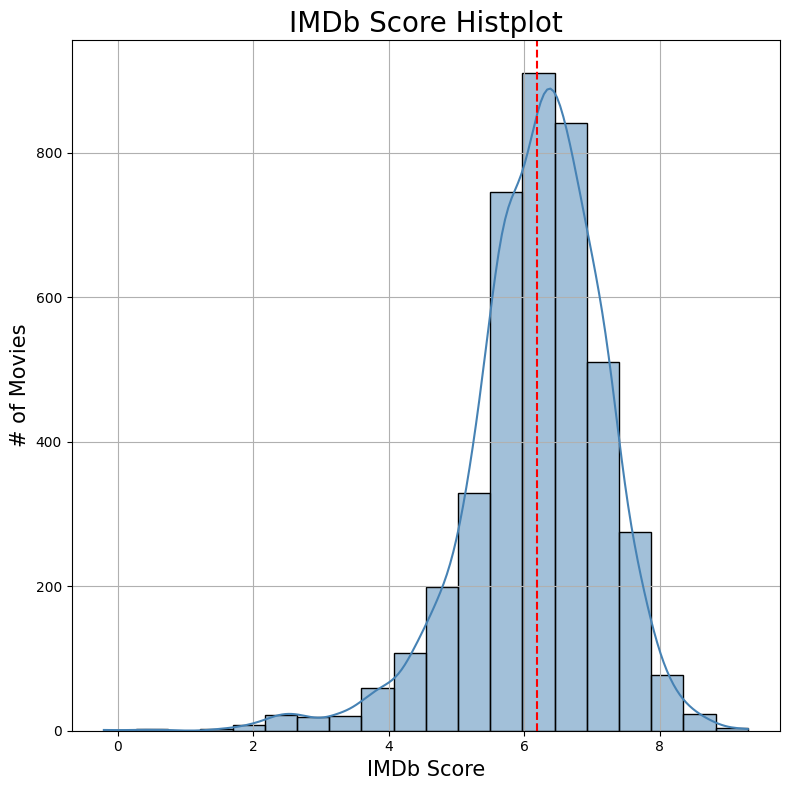

In [14]:
# Convert imdb_score column to Pandas for plotting
ratings_pd = df.select("imdb_score").dropna().toPandas()

# Plot using seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 8))
sns.histplot(ratings_pd['imdb_score'], kde=True, bins=20, color="steelblue")

plt.title("IMDb Score Histplot", size=20)
plt.xlabel("IMDb Score", size=15)
plt.ylabel("# of Movies", size=15)

# Add mean vertical line
plt.axvline(x=np.mean(ratings_pd['imdb_score']), color='red', linestyle='--')

plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from pyspark.sql import functions as F

total_score_df.select(F.mean("imdb_score")).show()


+-----------------+
|  avg(imdb_score)|
+-----------------+
|6.186060256340136|
+-----------------+



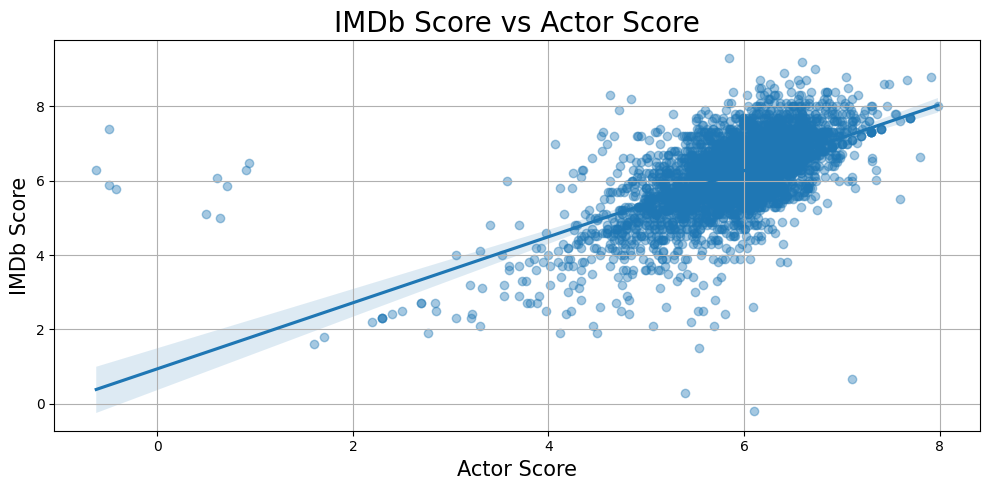

In [19]:
from pyspark.sql import functions as F

# Step 1: Filter out extreme outliers (actor_score > 10 is likely invalid)
filtered_df = total_score_df.filter(
    (F.col("actor_score") < 10) & (F.col("imdb_score") <= 10)
)

# Step 2: Drop missing and convert to pandas
ratings_pd = filtered_df.select("actor_score", "imdb_score").dropna().toPandas()

# Step 3: Plot using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.regplot(data=ratings_pd, x="actor_score", y="imdb_score", scatter_kws={'alpha':0.4})

plt.title("IMDb Score vs Actor Score", size=20)
plt.xlabel("Actor Score", size=15)
plt.ylabel("IMDb Score", size=15)
plt.grid(True)
plt.tight_layout()
plt.show()


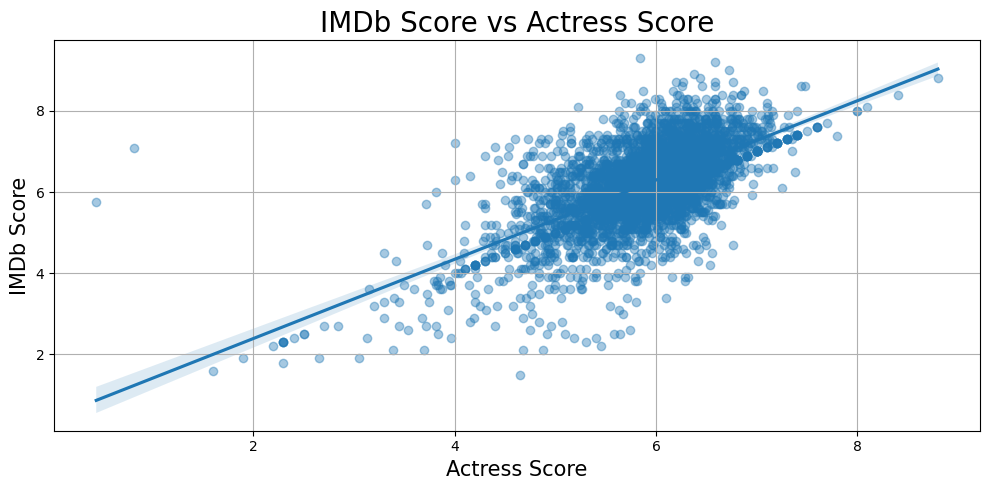

In [20]:
# Step 1: Convert selected columns to pandas after dropping nulls
ratings_pd = total_score_df.select("actress_score", "imdb_score") \
                           .filter("actress_score < 10 AND actress_score > 0") \
                           .dropna() \
                           .toPandas()

# Step 2: Plot using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.regplot(data=ratings_pd, x="actress_score", y="imdb_score", scatter_kws={'alpha':0.4})

plt.title("IMDb Score vs Actress Score", size=20)
plt.xlabel("Actress Score", size=15)
plt.ylabel("IMDb Score", size=15)
plt.grid(True)
plt.tight_layout()
plt.show()



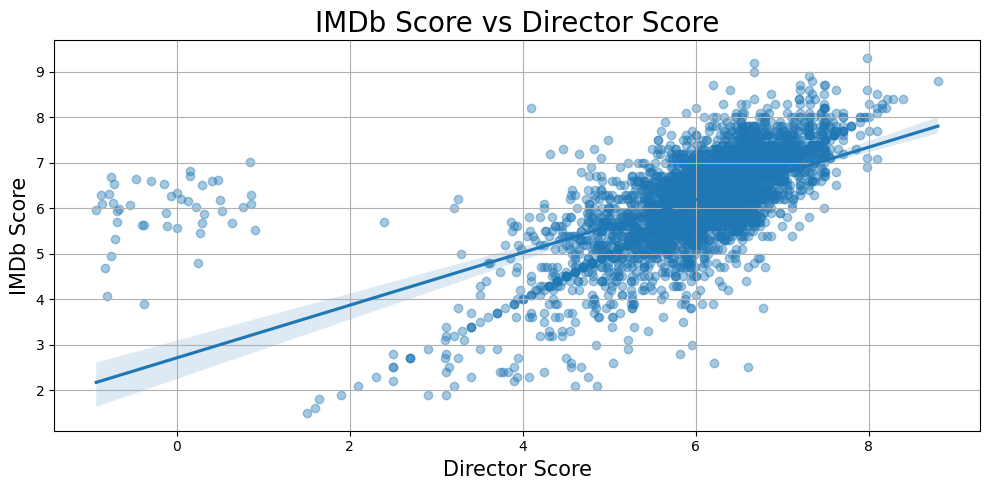

In [23]:
# Step 1: Convert to Pandas and filter out outliers
ratings_pd = (
    total_score_df
    .filter("director_score < 10")  # cap outliers
    .select("director_score", "imdb_score")
    .dropna()
    .toPandas()
)

# Step 2: Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Plot with Seaborn
plt.figure(figsize=(10, 5))
sns.regplot(data=ratings_pd, x="director_score", y="imdb_score", scatter_kws={'alpha': 0.4})
plt.title("IMDb Score vs Director Score", size=20)
plt.xlabel("Director Score", size=15)
plt.ylabel("IMDb Score", size=15)
plt.grid(True)
plt.tight_layout()
plt.show()


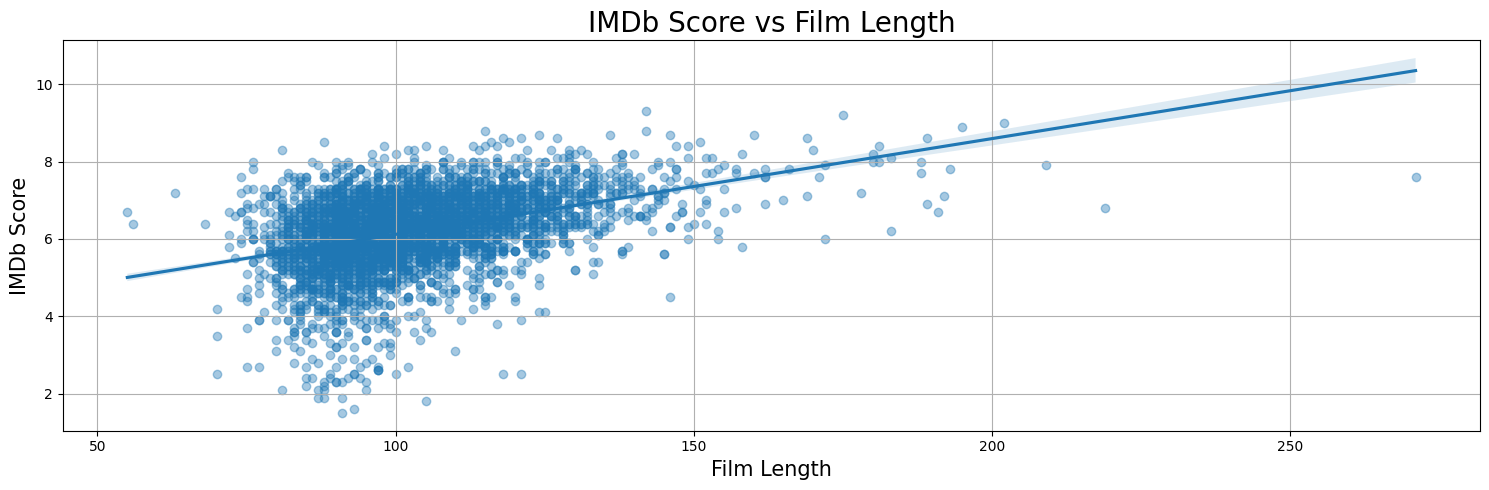

In [25]:
# Step 1: Convert selected columns to Pandas DataFrame
ratings_pd = total_score_df.select("duration", "imdb_score").dropna().toPandas()

# Ensure 'duration' is numeric
ratings_pd['duration'] = pd.to_numeric(ratings_pd['duration'], errors='coerce')
ratings_pd = ratings_pd.dropna()  # Remove rows where conversion failed

# Step 2: Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Plot
plt.figure(figsize=(15, 5))
sns.regplot(data=ratings_pd, x="duration", y="imdb_score", scatter_kws={'alpha': 0.4})

# Step 4: Labels
plt.title("IMDb Score vs Film Length", size=20)
plt.xlabel("Film Length", size=15)
plt.ylabel("IMDb Score", size=15)
plt.grid(True)
plt.tight_layout()
plt.show()


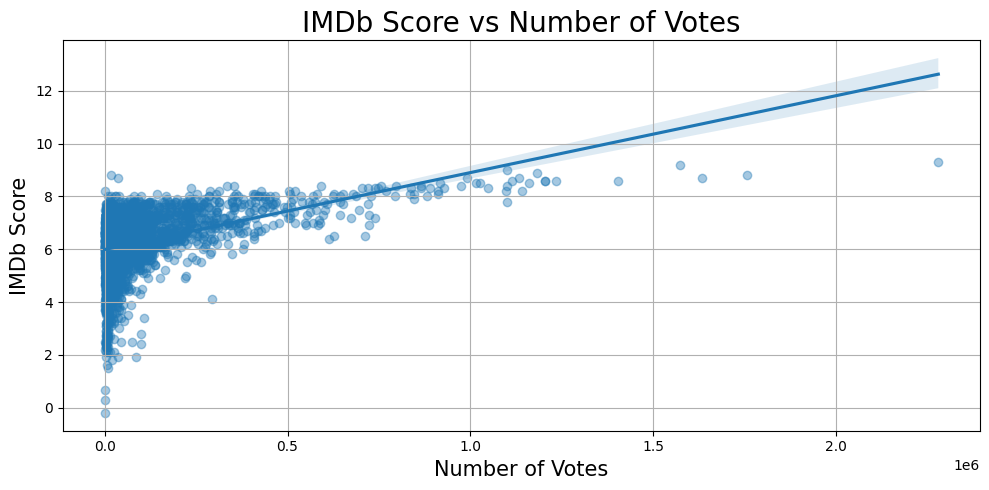

In [26]:
# Step 1: Convert required columns to Pandas DataFrame
ratings_pd = total_score_df.select("total_votes", "imdb_score").dropna().toPandas()

# Step 2: Ensure correct datatypes
ratings_pd['total_votes'] = pd.to_numeric(ratings_pd['total_votes'], errors='coerce')
ratings_pd = ratings_pd.dropna()

# Step 3: Plot using Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.regplot(data=ratings_pd, x="total_votes", y="imdb_score", scatter_kws={'alpha': 0.4})

# Step 4: Titles and labels
plt.title("IMDb Score vs Number of Votes", size=20)
plt.xlabel("Number of Votes", size=15)
plt.ylabel("IMDb Score", size=15)
plt.xticks()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
total_score_df.printSchema()


root
 |-- movie_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- actors: string (nullable = true)
 |-- plot: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- Action: string (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: string (nullable = true)
 |-- Biography: integer (nullable = true)
 |-- Comedy: integer (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Family: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- History: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Sci-Fi: integer (nullable = true)
 |-- Sport: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- War: integer (nullable = true)
 |-- Western: integer (nullable = true)
 |-- votes

In [31]:
revenue_df.printSchema()
revenue_df.select("budget").show(5)


root
 |-- movie_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- tagline: string (nullable = true)
 |-- plot: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- Action: string (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: string (nullable = true)
 |-- Biography: string (nullable = true)
 |-- Comedy: string (nullable = true)
 |-- Crime: string (nullable = true)
 |-- Drama: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Fantasy: string (nullable = true)
 |-- History: string (nullable = true)
 |-- Horror: string (nullable = true)
 |-- Music: string (nullable = true)
 |-- Musical: string (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)
 |-- Sport: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Western: double (nullable = 

In [32]:
# Join budget from revenue_df into total_score_df using movie title (or another key if available)
total_score_df = total_score_df.join(
    revenue_df.select("movie_title", "budget"),
    on="movie_title",
    how="left"
)

# Verify the schema now includes 'budget'
total_score_df.printSchema()


root
 |-- movie_title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- actors: string (nullable = true)
 |-- plot: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- Action: string (nullable = true)
 |-- Adventure: string (nullable = true)
 |-- Animation: string (nullable = true)
 |-- Biography: integer (nullable = true)
 |-- Comedy: integer (nullable = true)
 |-- Crime: integer (nullable = true)
 |-- Documentary: integer (nullable = true)
 |-- Drama: integer (nullable = true)
 |-- Family: integer (nullable = true)
 |-- Fantasy: integer (nullable = true)
 |-- History: integer (nullable = true)
 |-- Horror: integer (nullable = true)
 |-- Music: integer (nullable = true)
 |-- Mystery: integer (nullable = true)
 |-- Romance: integer (nullable = true)
 |-- Sci-Fi: integer (nullable = true)
 |-- Sport: integer (nullable = true)
 |-- Thriller: integer (nullable = true)
 |-- War: integer (nullable = true)
 |-- Western: integer (nullable = true)
 |-- votes

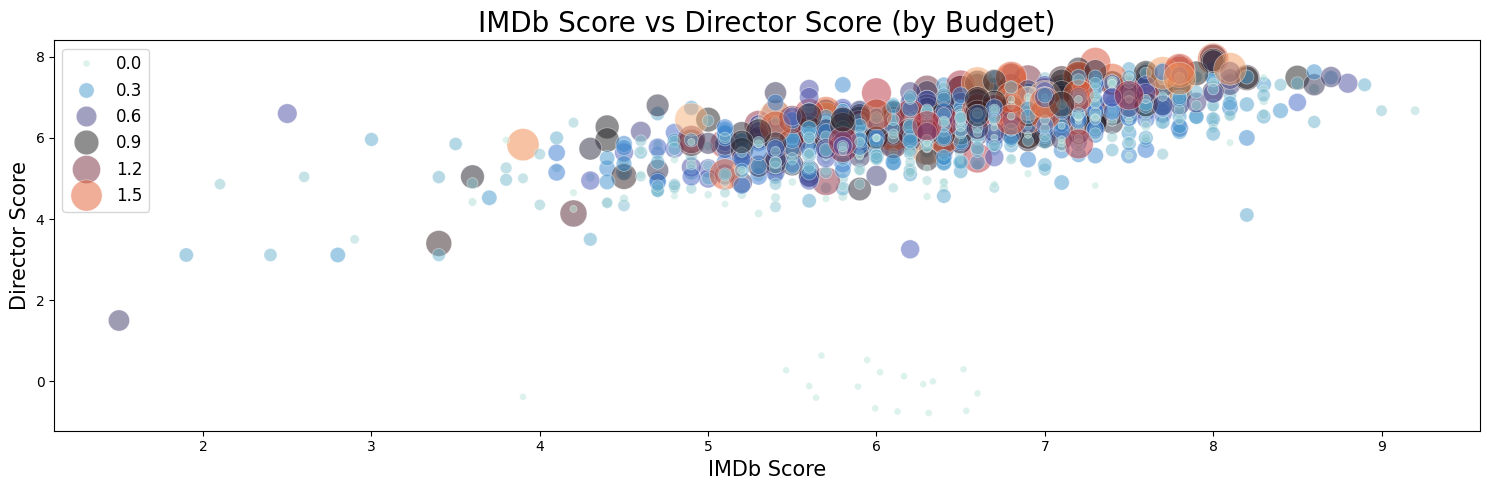

In [34]:
# Step 1: Convert to Pandas
ratings_pd = total_score_df.select("imdb_score", "director_score", "budget") \
    .dropna().toPandas()

# Step 2: Normalize the budget to match original chart scale
ratings_pd['budget'] = ratings_pd['budget'] / 1e8  # brings large values (like 300M) into 0.5–3.0 range

# Optional: Clip extreme outliers (optional but improves clarity)
ratings_pd = ratings_pd[ratings_pd['budget'] < ratings_pd['budget'].quantile(0.99)]
ratings_pd = ratings_pd[ratings_pd['director_score'] < ratings_pd['director_score'].quantile(0.99)]

# Step 3: Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.scatterplot(
    data=ratings_pd,
    x="imdb_score", y="director_score",
    hue="budget", size="budget",
    sizes=(25, 600),
    palette="icefire", alpha=0.5
)

plt.legend(loc='best', fontsize=12)
plt.title("IMDb Score vs Director Score (by Budget)", size=20)
plt.xlabel("IMDb Score", size=15)
plt.ylabel("Director Score", size=15)
plt.tight_layout()
plt.show()


In [35]:
from pyspark.sql.functions import col

revenue_df.filter(
    (col("imdb_score") < 3.5) & (col("director_score") < 4)
).orderBy(col("budget").desc()).show(1)


+-----------+----+-----------------+--------------------+--------------------+--------+------+---------+---------+---------+------+-----+-----+------+-------+-------+------+-----+-------+-------+-------+------+-----+--------+---+-------+-----------+---------------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+----------+--------------+-----------+-----------------+-----------------+--------------+----------+----------+------+-----------+-----------+-----------+
|movie_title|year|          tagline|                plot|                cast|duration|Action|Adventure|Animation|Biography|Comedy|Crime|Drama|Family|Fantasy|History|Horror|Music|Musical|Mystery|Romance|Sci-Fi|Sport|Thriller|War|Western|total_votes|us_voters_votes|   votes|votes_1|votes_2|votes_3|votes_4|votes_5|votes_6|votes_7|votes_8|votes_9|votes_10|popularity|director_score|actor_score|    actress_score|tagline_sentiment|plot_sentiment|imdb_score|profitable|budget|    revenue| budg

In [36]:
from pyspark.sql.functions import round as pyspark_round

revenue_df = revenue_df.withColumn("rounded_score_one", pyspark_round("imdb_score", 1))
revenue_df = revenue_df.withColumn("rounded_score_whole", pyspark_round("imdb_score", 0))


In [39]:
# Drop invalid IMDb scores (e.g., NaNs, negatives, or >10)
revenue_df = revenue_df.filter((revenue_df["imdb_score"] >= 0) & (revenue_df["imdb_score"] <= 10))

# Create rounded score columns again
revenue_df = revenue_df.withColumn("rounded_score_one", F.round("imdb_score", 1))
revenue_df = revenue_df.withColumn("rounded_score_whole", F.round("imdb_score"))


In [41]:
# Convert from Spark to Pandas
revenue_pd = revenue_df.select("imdb_score", "revenue").dropna().toPandas()


In [45]:
# Filter to keep only valid IMDb scores
revenue_pd = revenue_pd[(revenue_pd["imdb_score"] >= 1) & (revenue_pd["imdb_score"] <= 10)]

# Create rounded score columns
revenue_pd["rounded_score_one"] = revenue_pd["imdb_score"].round(1)
revenue_pd["rounded_score_whole"] = revenue_pd["imdb_score"].round()


<ipython-input-45-e0c4f8350ef7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue_pd["rounded_score_one"] = revenue_pd["imdb_score"].round(1)
<ipython-input-45-e0c4f8350ef7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue_pd["rounded_score_whole"] = revenue_pd["imdb_score"].round()


<ipython-input-46-5861f13fb866>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


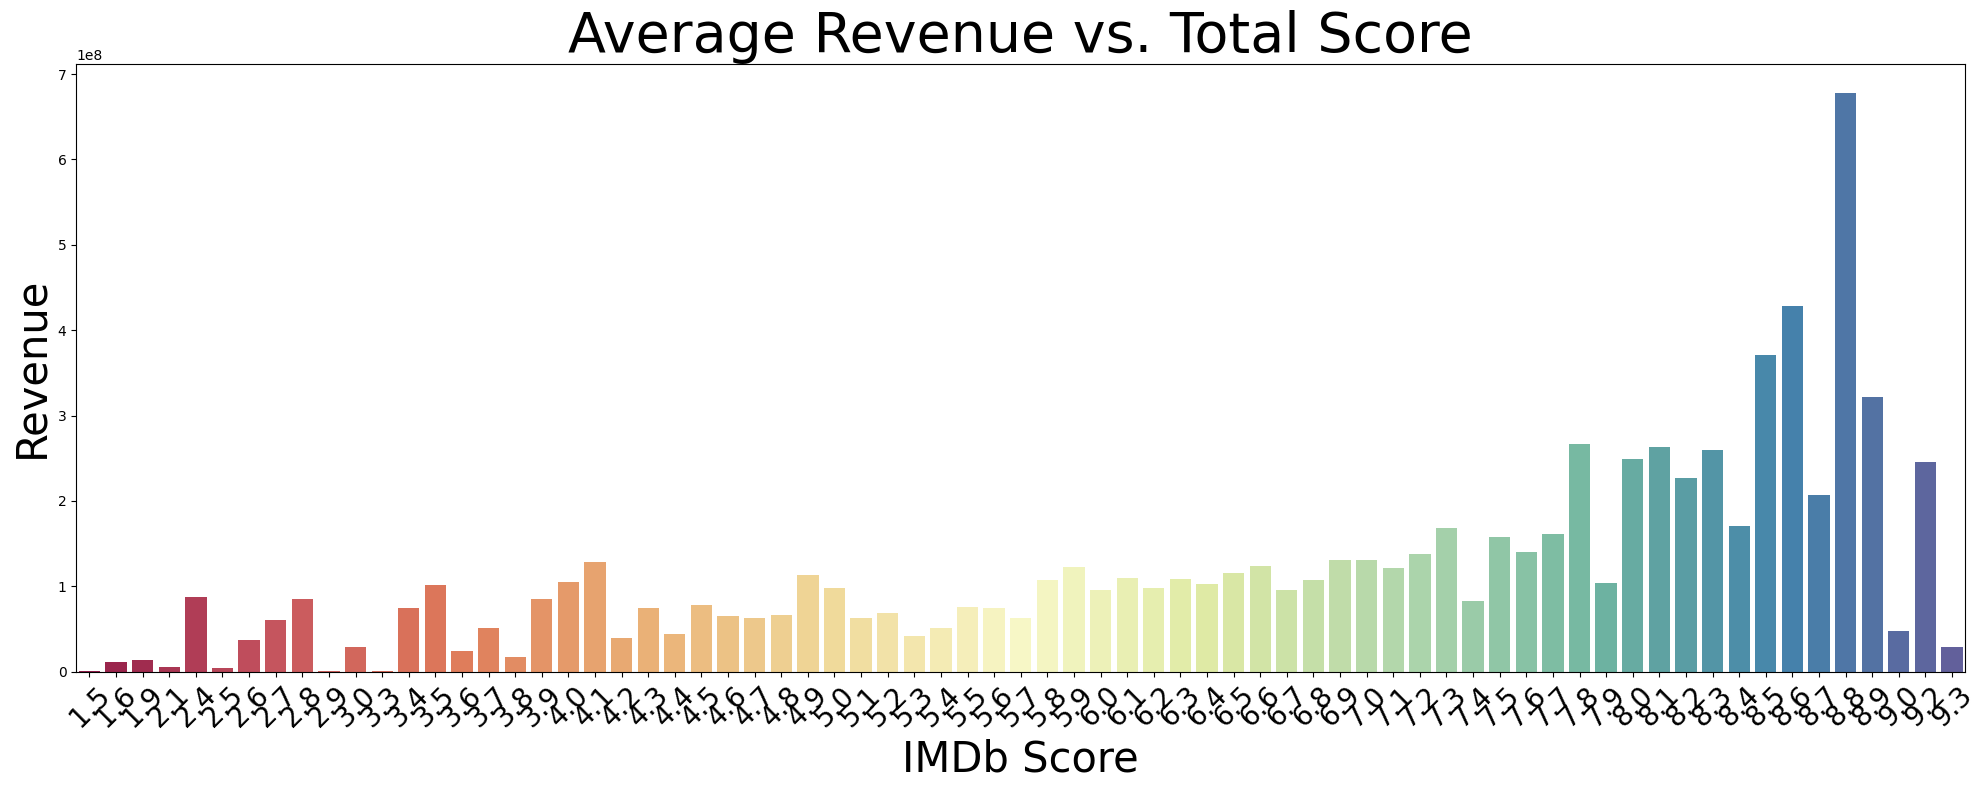

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Group by rounded IMDb score and calculate mean revenue
grouped_pd = revenue_pd.groupby("rounded_score_one").agg(average_revenue=("revenue", "mean")).reset_index()

# Step 2: Plot
plt.figure(figsize=(20, 8))
sns.barplot(
    x="rounded_score_one",
    y="average_revenue",
    data=grouped_pd,
    palette="Spectral"
)

# Step 3: Annotate
plt.title("Average Revenue vs. Total Score", size=40)
plt.xlabel("IMDb Score", size=30)
plt.ylabel("Revenue", size=30)
plt.xticks(
    ticks=np.arange(len(grouped_pd)),
    labels=np.round(grouped_pd["rounded_score_one"], 1),
    size=20,
    rotation=45
)
plt.tight_layout()
plt.show()


<ipython-input-47-712ab6e439a9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


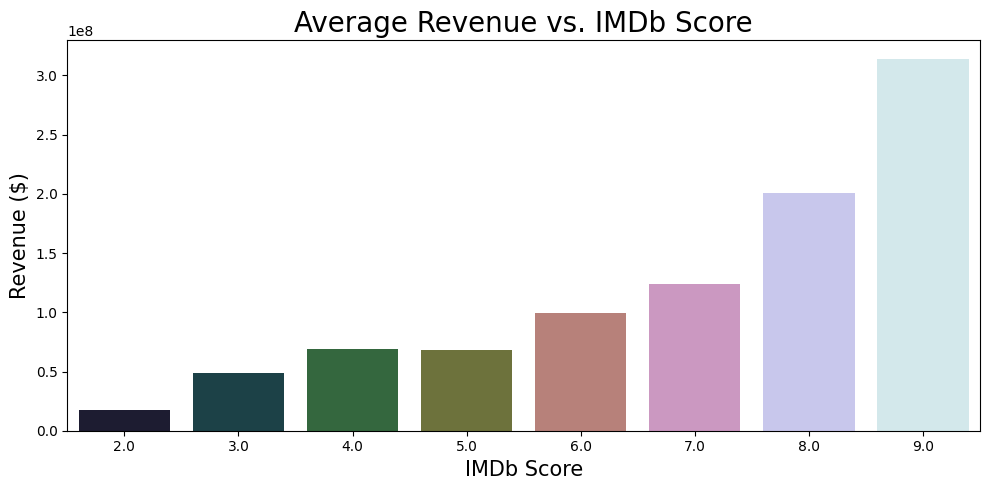

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by whole-number IMDb score and calculate mean revenue
average_rev = revenue_pd.groupby("rounded_score_whole")["revenue"].mean().reset_index()

# Step 2: Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=average_rev,
    x="rounded_score_whole",
    y="revenue",
    palette="cubehelix"
)

# Step 3: Titles and axis labels
plt.title("Average Revenue vs. IMDb Score", size=20)
plt.xlabel("IMDb Score", size=15)
plt.ylabel("Revenue ($)", size=15)
plt.tight_layout()

# Optional: Save the figure
# plt.savefig("../images/revenue_totalscore.png", bbox_inches="tight")

plt.show()


In [50]:
# Convert to Pandas first
total_score_pd = total_score_df.toPandas()
revenue_pd = revenue_df.toPandas()

# Define genres
genres = ['Action', 'Adventure', 'Animation', 'Biography',
          'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
          'Music', 'Mystery', 'Romance', 'Sci-Fi',
          'Sport', 'Thriller', 'War', 'Western']

# Containers to hold genre-wise results
genre_list = []
data = []             # IMDb mean scores
revenues = []
budgets = []
plot_sent = []
tag_sent = []
actor_scores = []
actress_scores = []
director_scores = []

# Loop over genres
for genre in genres:
    genre_list.append(genre)

    mean_score = total_score_pd.loc[total_score_pd[genre] == 1, 'imdb_score'].mean()
    data.append(mean_score)

    avg_revenue = revenue_pd.loc[revenue_pd[genre] == 1, 'revenue'].mean()
    revenues.append(int(avg_revenue) if pd.notnull(avg_revenue) else 0)

    budget = revenue_pd.loc[revenue_pd[genre] == 1, 'budget'].mean()
    budgets.append(int(budget) if pd.notnull(budget) else 0)

    plot_sentiment = total_score_pd.loc[total_score_pd[genre] == 1, 'plot_sentiment'].mean()
    plot_sent.append(plot_sentiment)

    tag_sentiment = revenue_pd.loc[revenue_pd[genre] == 1, 'tagline_sentiment'].mean()
    tag_sent.append(tag_sentiment)

    actor_score = total_score_pd.loc[total_score_pd[genre] == 1, 'actor_score'].mean()
    actor_scores.append(actor_score)

    actress_score = total_score_pd.loc[total_score_pd[genre] == 1, 'actress_score'].mean()
    actress_scores.append(actress_score)

    director_score = total_score_pd.loc[total_score_pd[genre] == 1, 'director_score'].mean()
    director_scores.append(director_score)


In [51]:
import pandas as pd

genre_summary_df = pd.DataFrame({
    'Genre': genre_list,
    'IMDb Score': data,
    'Revenue': revenues,
    'Budget': budgets,
    'Plot Sentiment': plot_sent,
    'Tagline Sentiment': tag_sent,
    'Actor Score': actor_scores,
    'Actress Score': actress_scores,
    'Director Score': director_scores
})

genre_summary_df.head()


,Genre,IMDb Score,Revenue,Budget,Plot Sentiment,Tagline Sentiment,Actor Score,Actress Score,Director Score
0,Action,NaN,0,0,NaN,NaN,NaN,NaN,NaN
1,Adventure,NaN,0,0,NaN,NaN,NaN,NaN,NaN
2,Animation,NaN,0,0,NaN,NaN,NaN,NaN,NaN
3,Biography,6.979433,0,0,1555.510528,NaN,832.240794,6.191291,6.484036
4,Comedy,6.062175,0,0,99.531426,NaN,92.460718,5.867435,6.027071


In [54]:
total_score_df.columns


['movie_title',
 'year',
 'actors',
 'plot',
 'duration',
 'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western',
 'votes',
 'weighted_average_vote',
 'total_votes',
 'mean_vote',
 'median_vote',
 'votes_1',
 'votes_2',
 'votes_3',
 'votes_4',
 'votes_5',
 'votes_6',
 'votes_7',
 'votes_8',
 'votes_9',
 'votes_10',
 'us_voters_rating',
 'us_voters_votes',
 'plot_sentiment',
 'director_score',
 'actor_score',
 'actress_score',
 'imdb_score',
 'budget']

In [56]:
total_score_df = total_score_df.toPandas()
revenue_df = revenue_df.toPandas()


In [57]:
# Define genres
genres = ['Action', 'Adventure', 'Animation', 'Biography',
          'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
          'Music', 'Mystery', 'Romance', 'Sci-Fi',
          'Sport', 'Thriller', 'War', 'Western']

# Containers
genre_list = []
data = []           # IMDb
revenues = []       # Revenue
budgets = []        # Budget
plot_sent = []      # Plot sentiment
tag_sent = []       # Tagline sentiment
actor_scores = []   # Actor
actress_scores = [] # Actress
director_scores = []# Director

# Loop per genre
for genre in genres:
    genre_list.append(genre)

    df_mask = total_score_df[genre] == 1

    data.append(total_score_df.loc[df_mask, 'imdb_score'].mean())
    revenues.append(revenue_df.loc[df_mask, 'revenue'].mean())
    budgets.append(revenue_df.loc[df_mask, 'budget'].mean())
    plot_sent.append(total_score_df.loc[df_mask, 'plot_sentiment'].mean())
    tag_sent.append(revenue_df.loc[df_mask, 'tagline_sentiment'].mean())
    actor_scores.append(total_score_df.loc[df_mask, 'actor_score'].mean())
    actress_scores.append(total_score_df.loc[df_mask, 'actress_score'].mean())
    director_scores.append(total_score_df.loc[df_mask, 'director_score'].mean())


In [58]:
# Build final summary DataFrame
imdb_scores = pd.DataFrame({
    'Genre': genre_list,
    'Avg_IMDbScore': data,
    'Avg_Budget': budgets,
    'Avg_Revenue': revenues,
    'Avg_PlotSentiment': plot_sent,
    'Avg_TaglineSentiment': tag_sent,
    'Avg_ActorScore': actor_scores,
    'Avg_ActressScore': actress_scores,
    'Avg_DirectorScore': director_scores
})

# Compute ROI and Casting Score
imdb_scores['ROI'] = imdb_scores['Avg_Revenue'] / imdb_scores['Avg_Budget']
imdb_scores['Casting_Score'] = (
    imdb_scores['Avg_ActorScore'] +
    imdb_scores['Avg_ActressScore'] +
    imdb_scores['Avg_DirectorScore']
)

# Preview
imdb_scores.head()


,Genre,Avg_IMDbScore,Avg_Budget,Avg_Revenue,Avg_PlotSentiment,Avg_TaglineSentiment,Avg_ActorScore,Avg_ActressScore,Avg_DirectorScore,ROI,Casting_Score
0,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adventure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Animation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Biography,6.979433,3.179890e+07,1.014689e+08,1555.510528,0.143885,832.240794,6.191291,6.484036,3.190956,844.916121
4,Comedy,6.062175,3.661364e+07,1.056110e+08,99.531426,4.440882,92.460718,5.867435,6.027071,2.884471,104.355225


In [59]:
# Check unique values in a few genre columns
for g in ['Action', 'Adventure', 'Animation']:
    print(f"{g} unique values:", total_score_df[g].unique())


Action unique values: ['0' '1' '119' '102' '89' '126' '127' '116' '114' '91' '135'
 ' a well-mannered student who awakens a sense of sexual possessiveness in her teacher."'
 '105' '122' '82' ' and anti-establishment types ..."'
 ' when he is accidentally killed by his own soldiers."' '97' '104'
 ' risking his job and finding clues when it\'s clear the man is healthy."'
 '100' '81' '156' ' football player Flesh Gordon"' '88' '115' '94' '87'
 None " has captured the country's attention"
 ' doing things they never would have imagined' '93' '95' '96' ' ..."'
 ' using humour and pathos."' '83' " from Jack's former pirate allies"
 ' now friends' '98'
 ' a boxing legend believed to have passed away. What begins as an opportunity to resurrect Champ\'s story and escape the shadow of his father\'s success becomes a personal journey as the ambitious reporter reexamines his own life and his relationship with his family."'
 '108' '130' '106' '86'
 '"" and decide to find someone who is on the verge'

In [62]:
genres = ['Action', 'Adventure', 'Animation', 'Biography',
          'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
          'Music', 'Mystery', 'Romance', 'Sci-Fi',
          'Sport', 'Thriller', 'War', 'Western']

# Convert corrupted genre values to binary (1 if likely belongs, else 0)
for g in genres:
    total_score_df[g] = total_score_df[g].astype(str).str.strip().isin(['1', '1.0']).astype(int)


In [64]:
import pandas as pd

# Define genre columns
genres = ['Action', 'Adventure', 'Animation', 'Biography',
          'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
          'Music', 'Mystery', 'Romance', 'Sci-Fi',
          'Sport', 'Thriller', 'War', 'Western']

# STEP 1: Clean genre columns — convert valid binary flags
for g in genres:
    total_score_df[g] = total_score_df[g].astype(str).str.strip().isin(['1', '1.0']).astype(int)

# STEP 2: Initialize containers for genre-wise stats
genre_list = []
data = []           # IMDb score
revenues = []       # revenue
budgets = []        # budget
plot_sent = []      # plot sentiment
tag_sent = []       # tagline sentiment
actor_scores = []   # actor
actress_scores = [] # actress
director_scores = []# director

# STEP 3: Compute average values for each genre
for genre in genres:
    df_mask = total_score_df[genre] == 1

    genre_list.append(genre)
    data.append(total_score_df[df_mask]['imdb_score'].mean())
    revenues.append(revenue_df[df_mask]['revenue'].mean())
    budgets.append(revenue_df[df_mask]['budget'].mean())
    plot_sent.append(total_score_df[df_mask]['plot_sentiment'].mean())
    tag_sent.append(revenue_df[df_mask]['tagline_sentiment'].mean())
    actor_scores.append(total_score_df[df_mask]['actor_score'].mean())
    actress_scores.append(total_score_df[df_mask]['actress_score'].mean())
    director_scores.append(total_score_df[df_mask]['director_score'].mean())


# STEP 4: Build the summary DataFrame
imdb_scores = pd.DataFrame({
    'Genre': genre_list,
    'Avg_IMDbScore': data,
    'Avg_Budget': budgets,
    'Avg_Revenue': revenues,
    'Avg_PlotSentiment': plot_sent,
    'Avg_TaglineSentiment': tag_sent,
    'Avg_ActorScore': actor_scores,
    'Avg_ActressScore': actress_scores,
    'Avg_DirectorScore': director_scores
})

# STEP 5: Add ROI and Casting Score
imdb_scores['ROI'] = imdb_scores['Avg_Revenue'] / imdb_scores['Avg_Budget']
imdb_scores['Casting_Score'] = (
    imdb_scores['Avg_ActorScore'] +
    imdb_scores['Avg_ActressScore'] +
    imdb_scores['Avg_DirectorScore']
)

# Preview result
imdb_scores.head()


<ipython-input-64-6a0aaf3559fd>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  revenues.append(revenue_df[df_mask]['revenue'].mean())
<ipython-input-64-6a0aaf3559fd>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  budgets.append(revenue_df[df_mask]['budget'].mean())
<ipython-input-64-6a0aaf3559fd>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tag_sent.append(revenue_df[df_mask]['tagline_sentiment'].mean())
<ipython-input-64-6a0aaf3559fd>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  revenues.append(revenue_df[df_mask]['revenue'].mean())
<ipython-input-64-6a0aaf3559fd>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  budgets.append(revenue_df[df_mask]['budget'].mean())
<ipython-input-64-6a0aaf3559fd>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tag_sent.append(revenue_df[df_mask]

,Genre,Avg_IMDbScore,Avg_Budget,Avg_Revenue,Avg_PlotSentiment,Avg_TaglineSentiment,Avg_ActorScore,Avg_ActressScore,Avg_DirectorScore,ROI,Casting_Score
0,Action,6.122664,3.540891e+07,1.031221e+08,-0.258730,0.069305,5.886674,5.835591,6.051854,2.912320,17.774118
1,Adventure,6.286073,3.836771e+07,1.056148e+08,665.951399,0.074677,6.032512,6.005602,6.121613,2.752699,18.159728
2,Animation,6.604090,3.367630e+07,9.756091e+07,2294.241805,0.186448,6.194185,6.159549,6.252811,2.897020,18.606546
3,Biography,6.979433,3.179890e+07,1.014689e+08,1555.510528,0.143885,832.240794,6.191291,6.484036,3.190956,844.916121
4,Comedy,6.062175,3.661364e+07,1.056110e+08,99.531426,4.440882,92.460718,5.867435,6.027071,2.884471,104.355225


In [65]:
total_score_df['plot_sentiment'] = pd.to_numeric(total_score_df['plot_sentiment'], errors='coerce')
revenue_df['tagline_sentiment'] = pd.to_numeric(revenue_df['tagline_sentiment'], errors='coerce')


In [66]:
total_score_df['actor_score'] = pd.to_numeric(total_score_df['actor_score'], errors='coerce')
total_score_df['actress_score'] = pd.to_numeric(total_score_df['actress_score'], errors='coerce')
total_score_df['director_score'] = pd.to_numeric(total_score_df['director_score'], errors='coerce')


In [67]:
total_score_df = total_score_df[
    (total_score_df['actor_score'] < 10) &
    (total_score_df['actress_score'] < 10) &
    (total_score_df['director_score'] < 10)
]


In [72]:
# Convert relevant columns to numeric in total_score_df
total_score_cols = ['imdb_score', 'budget', 'plot_sentiment',
                    'actor_score', 'actress_score', 'director_score']
for col in total_score_cols:
    total_score_df[col] = pd.to_numeric(total_score_df[col], errors='coerce')

# Convert relevant columns to numeric in revenue_df
revenue_cols = ['revenue', 'budget', 'tagline_sentiment']
for col in revenue_cols:
    revenue_df[col] = pd.to_numeric(revenue_df[col], errors='coerce')


<ipython-input-72-abd25e95c4b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_score_df[col] = pd.to_numeric(total_score_df[col], errors='coerce')


In [73]:
import pandas as pd

# Step 1: Convert relevant columns to numeric (if not already)
total_score_cols = ['imdb_score', 'budget', 'plot_sentiment',
                    'actor_score', 'actress_score', 'director_score']
for col in total_score_cols:
    total_score_df[col] = pd.to_numeric(total_score_df[col], errors='coerce')

revenue_cols = ['revenue', 'budget', 'tagline_sentiment']
for col in revenue_cols:
    revenue_df[col] = pd.to_numeric(revenue_df[col], errors='coerce')

# Step 2: Define genres
genres = ['Action', 'Adventure', 'Animation', 'Biography',
          'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
          'Music', 'Mystery', 'Romance', 'Sci-Fi',
          'Sport', 'Thriller', 'War', 'Western']

# Step 3: Initialize containers
genre_list = []
data, revenues, budgets = [], [], []
plot_sent, tag_sent = [], []
actor_scores, actress_scores, director_scores = [], [], []

# Step 4: Loop over genres
for genre in genres:
    genre_list.append(genre)
    df_mask = total_score_df[genre] == 1

    data.append(total_score_df.loc[df_mask, 'imdb_score'].mean())
    revenues.append(revenue_df.loc[df_mask, 'revenue'].mean())
    budgets.append(revenue_df.loc[df_mask, 'budget'].mean())
    plot_sent.append(total_score_df.loc[df_mask, 'plot_sentiment'].mean())
    tag_sent.append(revenue_df.loc[df_mask, 'tagline_sentiment'].mean())
    actor_scores.append(total_score_df.loc[df_mask, 'actor_score'].mean())
    actress_scores.append(total_score_df.loc[df_mask, 'actress_score'].mean())
    director_scores.append(total_score_df.loc[df_mask, 'director_score'].mean())

# Step 5: Build final summary DataFrame
imdb_scores = pd.DataFrame({
    'Genre': genre_list,
    'Avg_IMDbScore': data,
    'Avg_Budget': budgets,
    'Avg_Revenue': revenues,
    'Avg_PlotSentiment': plot_sent,
    'Avg_TaglineSentiment': tag_sent,
    'Avg_ActorScore': actor_scores,
    'Avg_ActressScore': actress_scores,
    'Avg_DirectorScore': director_scores
})

# Step 6: Add derived metrics
imdb_scores['ROI'] = imdb_scores['Avg_Revenue'] / imdb_scores['Avg_Budget']
imdb_scores['Casting_Score'] = (imdb_scores['Avg_ActorScore'] +
                                imdb_scores['Avg_ActressScore'] +
                                imdb_scores['Avg_DirectorScore'])

# Step 7: Preview result
imdb_scores.head()


<ipython-input-73-82ce8a2b034d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_score_df[col] = pd.to_numeric(total_score_df[col], errors='coerce')


AssertionError: 